# Vertical Integraion Tutorial for ST and SM Data

This tutorial demonstrates the process of vertically integrating spatial transcriptomics (ST) and spatial metabolomics (SM) data using spatialMETA. 

In [1]:
cd ..

/home/rolan/Documents/spatialMETA


/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

## Read and preprocess data

In this section, we read and preprocess the joint SM and ST data. The steps include removing unwanted genes, normalizing the data, identifying spatial variable genes and metabolites, and selecting the subset of spatial variable genes and metaboliyes for further analysis.

In [3]:
# If data is available
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_raw.h5ad")

In [ ]:
#Test data can be obtained from SpatialMETA
joint_adata = smt.data.load_adata(
    sample_name="Y7_T_raw",
    modality="joint"
)

In [4]:
joint_adata = smt.pp.removeHSP_MT_RPL_DNAJ(joint_adata)

In [5]:
joint_adata.layers["counts"] = joint_adata.X.copy()

In [6]:
smt.pp.normalize_total_joint_adata_sm_st(joint_adata,
                         target_sum_SM=1e4,
                         target_sum_ST=1e4)

In [7]:
joint_adata.layers["normalized"] = joint_adata.X.copy()

In [8]:
joint_adata.raw = joint_adata

In [9]:
smt.pp.spatial_variable_joint_adata_sm_st(joint_adata,
                                         n_top_genes = 2000,
                                         n_top_metabolites = 800,
                                         add_key = "highly_variable_moranI")

In [10]:
joint_adata = joint_adata[:,joint_adata.var.highly_variable_moranI]

In [11]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800.h5ad")

## ConditionalVAE model for vertical integration

In this section, we train a ConditionalVAE model on the preprocessed joint SM and ST data. The VAE model learns a low-dimensional representation of the data that captures the underlying structure and relationships between the SM and ST measurements.

In [12]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800.h5ad")

In [13]:
joint_adata.X = joint_adata.layers["counts"]

In [14]:
smt.pp.normalize_total_joint_adata_sm_st(
    joint_adata,
    target_sum_SM=1e3,
    target_sum_ST=None
)

In [15]:
model = smt.model.ConditionalVAESTSM(
    joint_adata,
    device='cuda:0',
    reconstruction_method_sm='g',
    reconstruction_method_st='zinb',
)

In [16]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    mode='single'
)

/home/rolan/Documents/spatialMETA/spatialmeta/util/logger.py:151: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm_notebook
Epoch 64: 100%|██████████| 64/64 [00:18<00:00,  3.42it/s, reconst_sm=-8.60e+01, reconst_st=3.47e+02,


## Loss Visualization

In this section, we visualize the loss during the training of the ConditionalVAE model. The loss consists of three components: Kullback-Leibler divergence loss, reconstruction loss for spatial metabolomics (SM), and reconstruction loss for spatial transcriptomics (ST).

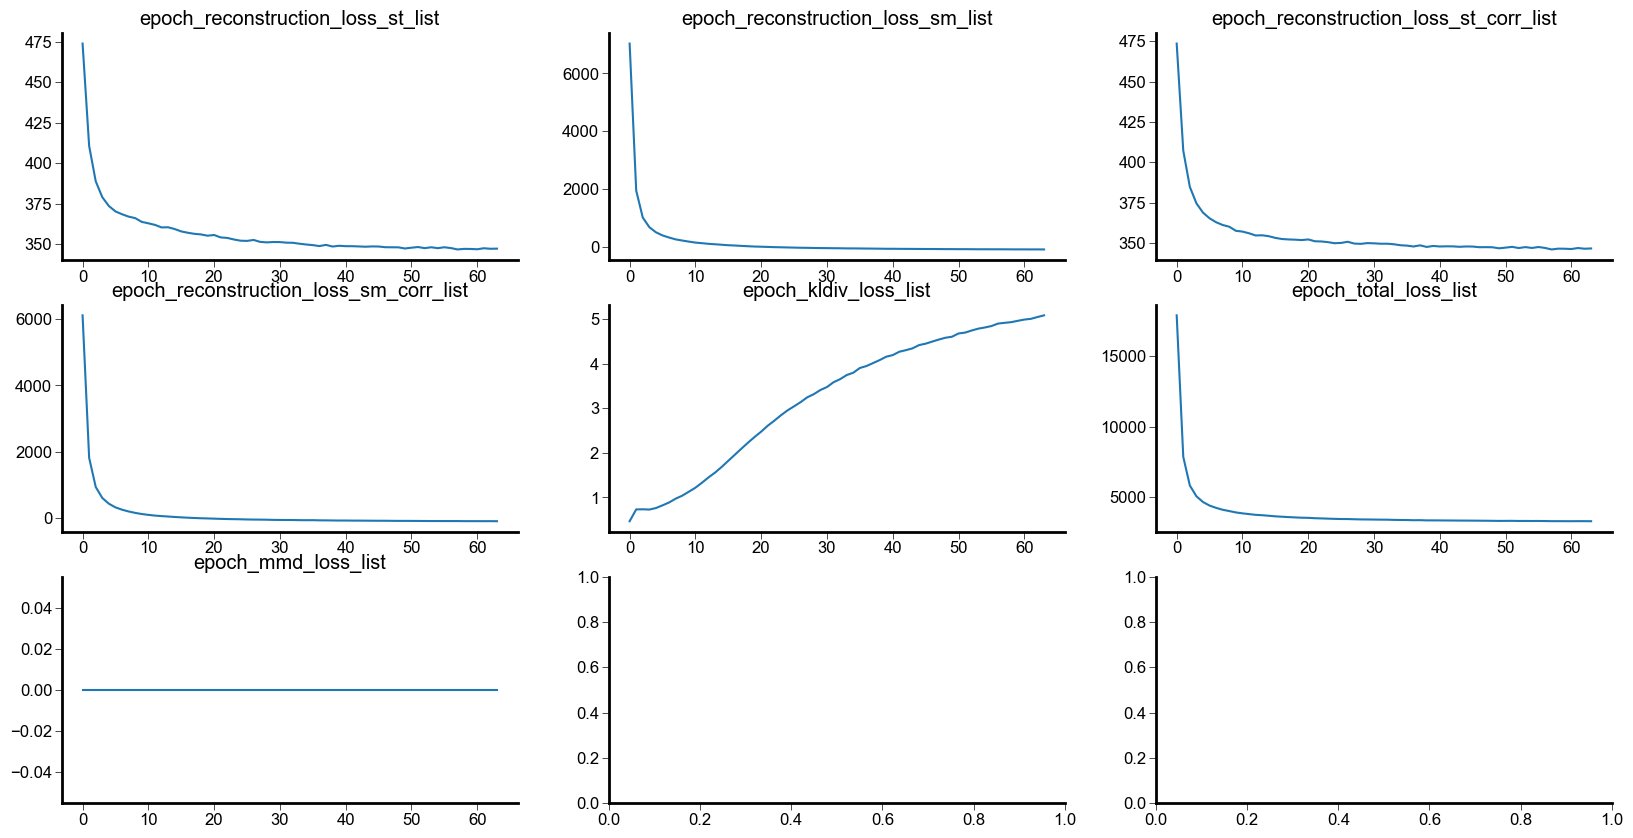

In [17]:
fig,axes=createSubplots(3,3,figsize=(20,10))
axes=axes.flatten()
for ax,(k,v) in zip(axes, loss_dict.items()):
    ax.plot(v)
    ax.set_title(k)

## Visualization and analysis

In this section, we visualize the results of the vertical integration using various plots and analysis techniques. We plot the loss curves during model training, visualize the latent space using UMAP, and explore the spatial patterns of specific genes or metabolites after denoising.

In [18]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()
C = model.get_modality_contribution()

Latent Embedding: 100%|██████████| 16/16 [00:00<00:00, 198.30it/s]                                  


In [19]:
joint_adata.layers['reconstruction'] = X
joint_adata.obsm['X_emb']=Z
joint_adata.obsm['contribution_st']=Z
joint_adata.obsm['contribution_sm']=1-Z

In [ ]:
sc.pp.neighbors(
    joint_adata,
    use_rep="X_emb",
    n_neighbors=15
)
sc.tl.umap(
    joint_adata,
    min_dist=1,
    spread=1
)
sc.tl.leiden(
    joint_adata, 
    key_added="VAE_clusters_latent10"
)

In [24]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800_spatialmeta.h5ad")

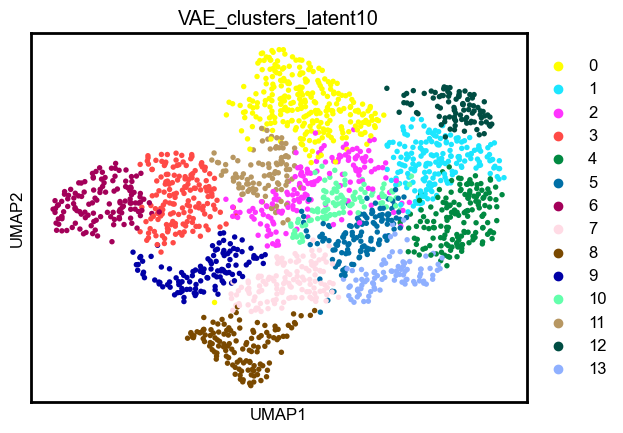

In [25]:
sc.pl.umap(
    joint_adata,
    color=["VAE_clusters_latent10"]
)

[<Axes: title={'center': 'VAE_clusters_latent10'}, xlabel='spatial1', ylabel='spatial2'>]

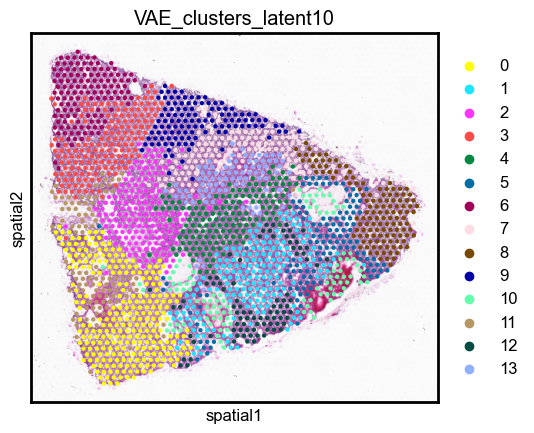

In [26]:
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["VAE_clusters_latent10"],
    show=False
)

[<Axes: title={'center': 'CD8A'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '137.04580812911064'}, xlabel='spatial1', ylabel='spatial2'>]

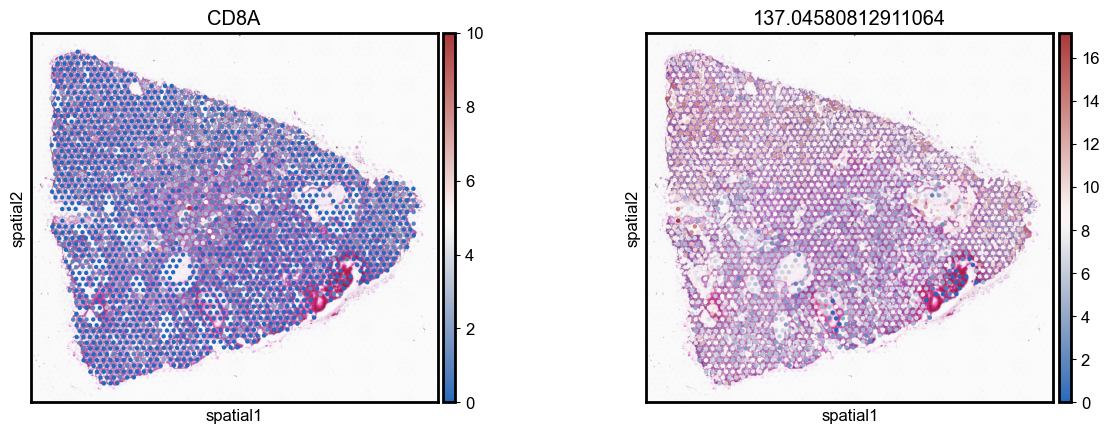

In [27]:
sc.pl.spatial(joint_adata, 
              img_key="hires", 
              color_map = "vlag",
              color=["CD8A","137.04580812911064"],
              layer="normalized",
              show=False)

[<Axes: title={'center': 'CD8A'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '137.04580812911064'}, xlabel='spatial1', ylabel='spatial2'>]

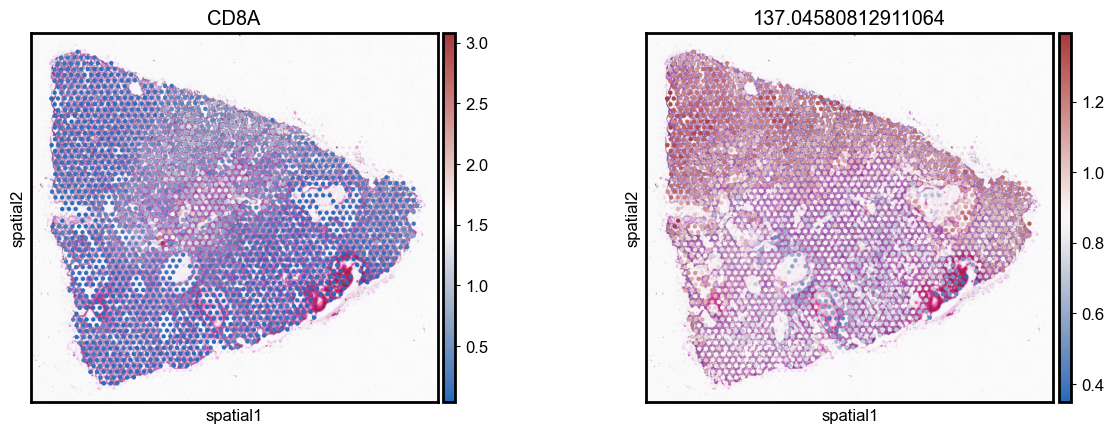

In [28]:
sc.pl.spatial(joint_adata, 
              img_key="hires", 
              color_map = "vlag",
              color=["CD8A","137.04580812911064"],
              layer="reconstruction",
              show=False)

[<Axes: title={'center': 'contribution_st'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'contribution_sm'}, xlabel='spatial1', ylabel='spatial2'>]

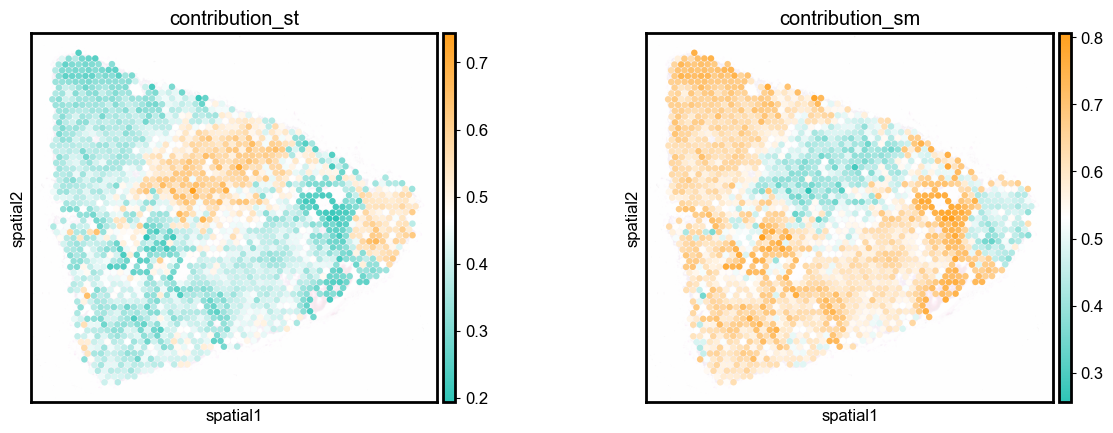

In [31]:
sc.pl.spatial(
    joint_adata,
    img_key="hires",
    color_map = smt.pl.make_colormap(['#2ec4b6','#ffffff','#ff9f1c' ]),
    color=['contribution_st','contribution_sm'],
    layer="normalized",
    show=False,
    alpha_img=0.1,
    size=1.5
)

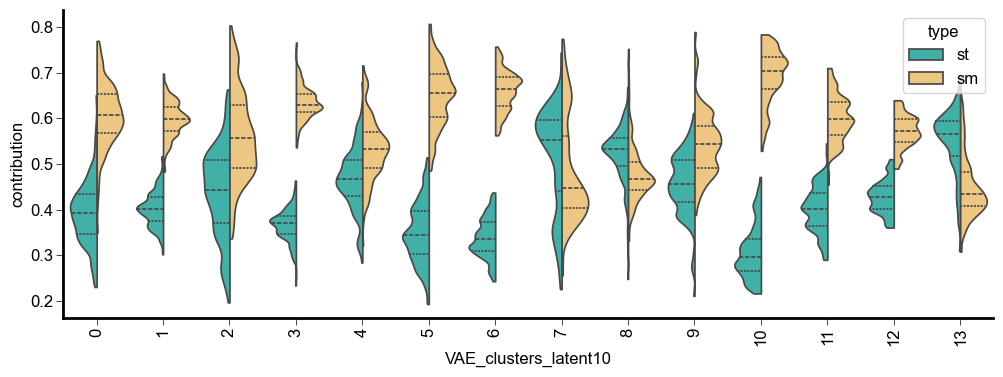

In [34]:
obs_df = joint_adata.obs
obs_filter_df = pd.concat([
    obs_df[['VAE_clusters_latent10', 'contribution_st']].rename(columns={'contribution_st': 'contribution'}).assign(type='st'),
    obs_df[['VAE_clusters_latent10', 'contribution_sm']].rename(columns={'contribution_sm': 'contribution'}).assign(type='sm')
])
fig,ax = smt.pl.create_fig(
    figsize = (12,4)
)
sns.violinplot(
    data=obs_filter_df,
    x="VAE_clusters_latent10",
    y="contribution",
    hue="type",
    split=True,
    inner="quart",
    palette=['#2ec4b6', '#FFCC70'],
    scale='width',  # Make violins the same width
    bw=0.2,         # Adjust smoothness (lower value = fatter violins)
    cut=0           # Limit the violin to data range
)

plt.xticks(rotation=90)
plt.show()

In [32]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800_spatialmeta.h5ad")